<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Cart Pendulum Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Cart Pendulum Problem:* We consider a cart-pendulum system with a pendulum of mass `m` and length `L`. The cart is actuated by a force `Fex` and the pendulum is subject to gravity `g`. The state of the system is described by the position of the cart `x` and the angle of the pendulum `θ`. The objective is to swing up the pendulum and stabilize it in the upright position in the shortest possible time.                                                                 
The problem is inspired from the following paper: [FATROP : A Fast Constrained Optimal Control Problem Solver for Robot Trajectory Optimization and Control](https://arxiv.org/pdf/2303.16746) made for [Casadi](https://web.casadi.org/) software and [Fatrop](https://github.com/meco-group/fatrop) solver.                            
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [1]:
import Pkg
Pkg.activate("..")
include("./utils.jl");

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [2]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/cart_pendulum_JMP.jl");
N= 200
CartJMP = Cart_Pendulum_JMP(;nh=N)

set_optimizer(CartJMP,Ipopt.Optimizer)
set_attribute(CartJMP, "print_level", 5)
set_optimizer_attribute(CartJMP,"tol",1e-8)
set_optimizer_attribute(CartJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(CartJMP,"max_iter",1000)
set_optimizer_attribute(CartJMP,"mu_strategy","adaptive")
set_attribute(CartJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(CartJMP, "linear_solver", "ma57")

In [3]:
println("Solving...")
optimize!(CartJMP)
println()

# Display results
if termination_status(CartJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(CartJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(CartJMP) == MOI.TIME_LIMIT && has_values(CartJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(CartJMP))
println()


# Retrieves values of variables

g = 9.82      # gravitation [m/s^2]
L = 1.0       # pendulum length [m]
m = 1.0       # pendulum mass [kg]
I = m*L^2/12  # pendulum moment of inertia
m_cart = 0.5  # cart mass [kg]
max_f = 5.0
max_x = 1.0
max_v = 2.0

tf = CartJMP[:tf]

x_ = CartJMP[:x];
dx_ = CartJMP[:dx];
theta_ = CartJMP[:theta];
omega_ = CartJMP[:omega];

u_ = CartJMP[:Fex];

con_d_x = CartJMP[:d_x];
con_d_dx = CartJMP[:d_dx];
con_d_theta = CartJMP[:d_theta];
con_d_omega = CartJMP[:d_omega];


Δt = value(tf)/N;
t = Vector((0:N)*Δt); 

p = - [[ dual(con_d_x[i]), dual(con_d_dx[i]), dual(con_d_theta[i]), dual(con_d_omega[i]) ] for i in 1:N];
p = costateInterpolatio(p, t);


x1 = Vector(value.(x_)) ;
dx = Vector(value.(dx_)) ;
theta = Vector(value.(theta_)) ;
omega = Vector(value.(omega_));
u = Vector(value.(u_)) ;

x =  [ [ x1[i], dx[i], theta[i], omega[i] ] for i in 1:N+1];

Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     6005
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    15200

Total number of variables............................:     1007
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      603
                     variables with only upper bounds:        0
Total number of equality constraints.................:      805
Total number of inequali

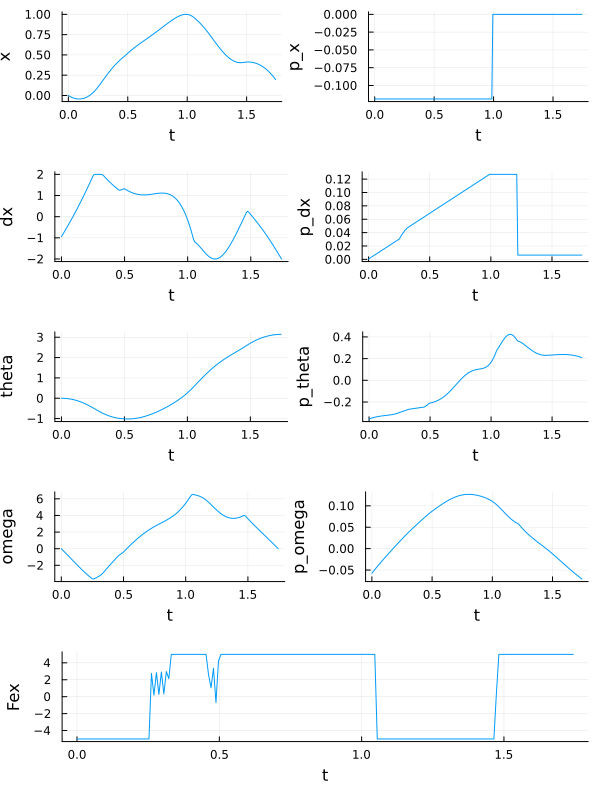

In [4]:
# For plotting results
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:N+1], xlabel = "t", ylabel = "dx", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "theta", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "omega", legend = false)

px1_plot = plot(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "p_x", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "p_dx", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "p_theta", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "p_omega", legend = false)

u_plot = plot(t, [ u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "Fex", legend = false)

layout = @layout [a b; c d; e f; g h ;j]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, x4_plot, px4_plot, u_plot, layout = layout)
x_plot = plot!(x_plot, size = (600, 800))
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [5]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/cart_pendulum_OC.jl")
CartOC = cart_pendulum_OC();

In [8]:
# Solve the problem
import HSL_jll
sol = OptimalControl.solve(CartOC,grid_size=N-1,
            linear_solver="ma57",hsllib=HSL_jll.libhsl_path)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:     5577
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     1601

Total number of variables............................:     1002
                     variables with only lower bounds:        1
                variables with lower and upper bounds:      600
                     variables with only upper bounds:        0
Total number of equality constraints.................:      801
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  1.0000000e-01 3.04e+00 0.00e+00   0.0 0.00e

CTBase.OptimalControlSolution

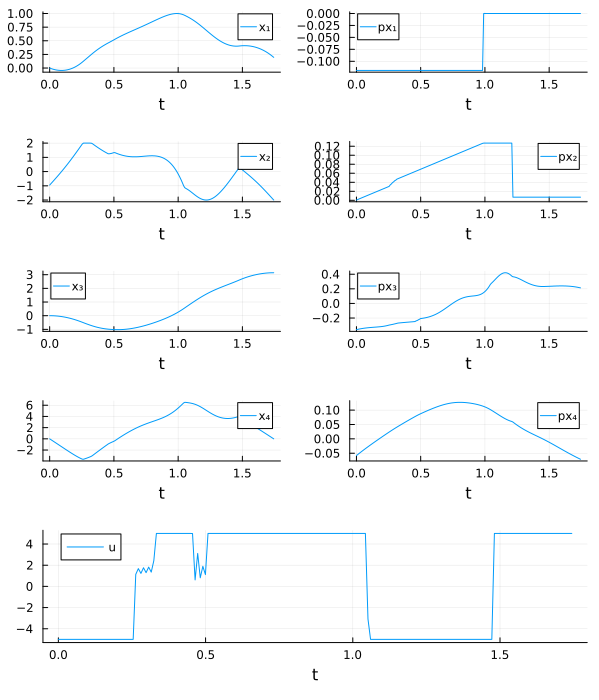

In [9]:
plot(sol)

## 3. Comparison <a id='comp'></a>

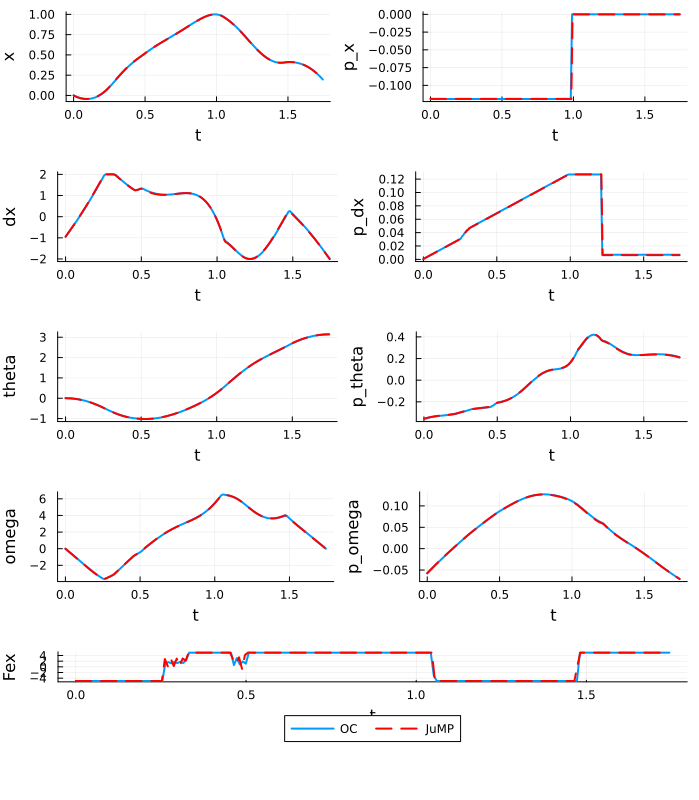

In [11]:
using Plots
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "x", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[2],line = 2)
p2 = plot!(t, [ x[i][2] for i in 1:N+1], xlabel = "t", ylabel = "dx", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[3],line = 2)
p3 = plot!(t, [ x[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "theta", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[4],line = 2)
p4 = plot!(t, [ x[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "omega", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[5],line = 2)
p5 = plot!(t, [ p[i][1] for i in 1:N+1 ], xlabel = "t", ylabel = "p_x", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[6],line = 2)
p6 = plot!(t, [ p[i][2] for i in 1:N+1 ], xlabel = "t", ylabel = "p_dx", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[7],line = 2)
p7 = plot!(t, [ p[i][3] for i in 1:N+1 ], xlabel = "t", ylabel = "p_theta", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[8],line = 2)
p8 = plot!(t, [ p[i][4] for i in 1:N+1 ], xlabel = "t", ylabel = "p_omega", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[9], label ="OC",line = 2)
p9 = plot!(t, [ u[i] for i in 1:N+1 ], xlabel = "t", ylabel = "Fex", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h ;j]

x_plot =  plot(p1,p5,p2,p6,p3,p7,p4,p8,p9, layout = layout)
x_plot = plot!(x_plot, size = (700, 800))
display(x_plot)